# **SDGym - Synthetic Data Gym**

**Synthetic Data Gym** (SDGym) is a framework to benchmark the performance of synthetic data generators based on SDV and SDMetrics:

*   Learn a tabular model to synthesize rows in a table
*   Learn a relational data model to synthesize multiple, related tables
*   Learn a time-series model to synthesize new events

GitHub Link: https://github.com/sdv-dev/SDGym

A **Synthetic Data Generator** is a Python function (or method) that takes as input some data, which we call the real data, learns a model from it, and outputs new synthetic data that has the same structure and similar mathematical properties as the real one.

In [ ]:
import os
import platform
OS = platform.system()   # Operating System                                                             # returns 'Windows', 'Linux', etc

# **Libraries Installation Section**

Installation of all required libraries: SDGym, gdown, pandas

In [ ]:
os.system('pip install --upgrade --no-cache-dir gdown')
os.system('pip install sdgym')
os.system('pip install pandas')

0

# **All Imports**

In [ ]:
import timeit
import numpy as np
import pandas as pd
from sdv.demo import load_tabular_demo
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN
from sdv.evaluation import evaluate

# **All Globals**

In [ ]:
benchmark = False
gaussian_copula_synth_model = False
ctgan_synth_model = False
copula_gan_synth_model = True
dataset = 'telephony'   # satgpa, acs, telephony
model_names = []
limit_to_generate = 1000  # or None

# **All Settings**

In [ ]:
start_global_time = timeit.default_timer()
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 
if ctgan_synth_model == True and copula_gan_synth_model == True: # Only one Gan 
  ctgan_synth_model = False

# **All Functions Definitions**

In [ ]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# **Data Download - ACS, SatGPA, Telephony**

In [ ]:
if benchmark == True: 
  data = load_tabular_demo('student_placements')
  n_to_generate = data.shape[0]
else: 
  if dataset is 'satgpa':
    out = data_download("./satgpa.csv", "1NNVF1LhBDkW_KKp5_QW8cAiQDFatzWMy", OS, False)
    data = pd.read_csv('./satgpa.csv')
    data = data.drop(['sat_sum'], axis=1)
    data.to_csv('satgpa_no_sum.csv', sep=',')
    n_to_generate = data.shape[0]
  elif dataset is 'acs':
    out = data_download("./acs_dataset.zip", "1mKZfDieGBJP-cS-R7_i3zVKVawXThfUc", OS)
    if limit_to_generate is not None: 
      data = pd.read_csv('./acs_dataset.csv', nrows = limit_to_generate)
      n_to_generate = limit_to_generate
    else: 
      data = pd.read_csv('./acs_dataset.csv')
      n_to_generate = data.shape[0]
  elif dataset is 'telephony':
    out = data_download("./syntetic_telephony.zip", "1knlC9DQ-iQhxwpmd9qzFWSS0OcgI9-LA", OS)
    xl_file = pd.ExcelFile('./syntetic_telephony.xlsx')
    dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
    data = dfs['Sheet1']
    n_to_generate = data.shape[0]

#**Data Types Conversions**

In [ ]:
data.COD_CELLA_CHIAMATA=data.COD_CELLA_CHIAMATA.astype("int64").astype("object")
data.DATA_CHIAMATA=pd.to_datetime(data.DATA_CHIAMATA, format='%Y%m%d')
data.CHIAVE_NUM_CHIAMANTE=data.CHIAVE_NUM_CHIAMANTE.astype("int64").astype("object")

data.ORA_MIN_CHIAMATA=data.ORA_MIN_CHIAMATA.astype("str").str.pad(width=6, side='left', fillchar='0')
data.ORA_MIN_CHIAMATA =pd.to_datetime(data.ORA_MIN_CHIAMATA , format='%H%M%S')

# **Exploratory Analysis**

In [ ]:
explore_data(data)


Head of Data: 
   CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
0    14615194667453690    2017-01-22 1900-01-01 15:49:53                  0
1    14615194667453690    2017-01-29 1900-01-01 12:40:34                  1
2    14615194667453690    2017-01-29 1900-01-01 12:41:19                  1
3    14615194667453690    2017-01-22 1900-01-01 15:51:02                  1
4    14615194667453690    2017-01-22 1900-01-01 15:51:38                  1

Tail of Data: 
      CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
9995    14615368752090240    2017-01-12 1900-01-01 12:09:10                272
9996    14615368752090240    2017-02-12 1900-01-01 18:26:01                272
9997     1508338528891430    2017-01-04 1900-01-01 09:26:27                272
9998    14615368752090240    2017-02-10 1900-01-01 15:11:58                272
9999    14615337422429130    2017-01-30 1900-01-01 09:09:03                272

Shape of Data:  (10000, 4)

Informa

# **Synthetic Data Generation via Gaussian Copula Method**

In mathematical terms, a copula is a distribution over the unit cube [0,1]d which is constructed from a multivariate normal distribution over Rd by using the probability integral transform. Intuitively, a copula is a mathematical function that allows us to describe the joint distribution of multiple random variables by analyzing the dependencies between their marginal distributions.

In [ ]:
if gaussian_copula_synth_model == True:
  train_start_time = timeit.default_timer()

  model = GaussianCopula()
  model.fit(data)
  model_names.append(dataset+'_gaussian_copula.pkl')
  model.save(model_names[-1])

  print("Gaussian Copula Training Exectution Time: ", timeit.default_timer() - train_start_time)

# **Synthetic Data Generation via Conditional GAN**

Modeling the probability distribution of rows in tabular data and generating realistic synthetic data is a non-trivial task. Tabular data usually contains a mix of discrete and continuous columns. Continuous columns may have multiple modes whereas discrete columns are sometimes imbalanced making the modeling difficult. Existing statistical and deep neural network models fail to properly model this type of data. We design TGAN, which uses a conditional generative adversarial network to address these challenges. To aid in a fair and thorough comparison, we design a benchmark with 7 simulated and 8 real datasets and several Bayesian network baselines. TGAN outperforms Bayesian methods on most of the real datasets whereas other deep learning methods could not.

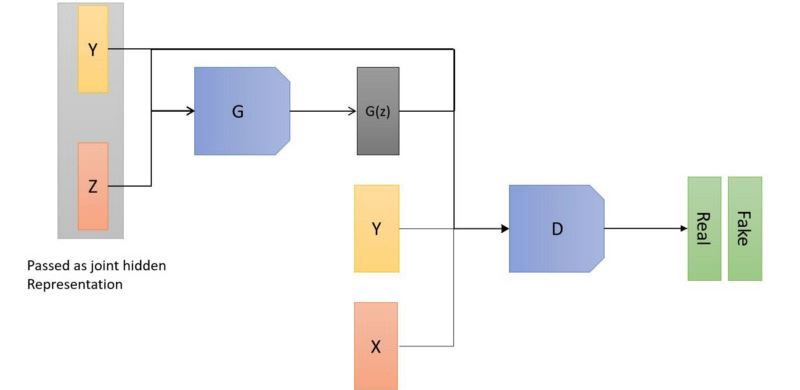

In [ ]:
if ctgan_synth_model == True:
  train_start_time = timeit.default_timer()
  
  model = CTGAN(
    epochs=500,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )
  model.fit(data)
  model_names.append(dataset+'_ctgan.pkl')
  model.save(model_names[-1])

  print("CTGAN Training Exectution Time: ", timeit.default_timer() - train_start_time)

# **Synthetic Data Generation via Copula GAN**

The CopulaGAN model is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.




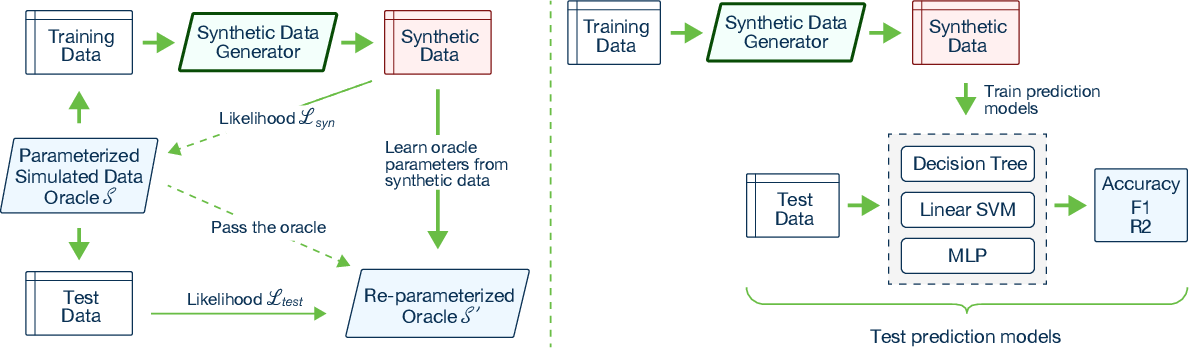

In [ ]:
if copula_gan_synth_model == True:
  train_start_time = timeit.default_timer()
  
  model = CopulaGAN(
    epochs=500,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
  )
  model.fit(data)
  model_names.append(dataset+'_copulagan.pkl')
  model.save(model_names[-1])

  print("Copula GAN Training Exectution Time: ", timeit.default_timer() - train_start_time)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:5320: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:5311: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: 

Copula GAN Training Exectution Time:  911.874614849


# **Model Loading and Preparation**

In [ ]:
model_file = []
model_to_load = []
if gaussian_copula_synth_model == True:
  model_file.append(model_names[0])
  model_to_load.append(("GaussianCopula", GaussianCopula))
if ctgan_synth_model == True:
  model_file.append(model_names[-1])
  model_to_load.append(("CTGAN", CTGAN))
elif copula_gan_synth_model == True:
  model_file.append(model_names[-1])
  model_to_load.append(("COPULAGAN", CopulaGAN))

loaded_model = []
for mf,ml in zip(model_file, model_to_load): 
  loaded_model.append((ml[0], ml[1].load(mf)))

# **Synthetic Data Generation**

In [ ]:
synthetic_data = []
for lm in loaded_model: 
  synthetic_data.append((lm[0], lm[1].sample(n_to_generate)))

# **Synthetic Data Exploratory Analysis**

In [ ]:
scored_and_synth_data = []
for sd in synthetic_data:
  try:
    print("\nMethod: ",sd[0])
    explore_data(sd[1])
    score = evaluate(sd[1], data)
    print("\n\nScore: ", score)
    scored_and_synth_data.append((sd[0], sd[1], score))  
  except:
    print("Error")



Method:  COPULAGAN

Head of Data: 
   CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
0    14626041936933770    2017-02-10 1900-01-01 00:00:26                 18
1    14632842300757262    2017-01-15 1900-01-01 20:49:42                517
2    14623653088778644    2017-01-22 1900-01-01 21:18:42                246
3    14622595996472314    2017-01-14 1900-01-01 17:21:20                 77
4    14620176174167388    2017-01-28 1900-01-01 11:38:19                633

Tail of Data: 
      CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA    ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
9995    14608228627110654    2017-01-12 1900-01-01 19:15:02                333
9996    14620303954350490    2017-02-03 1900-01-01 12:06:15                251
9997    14622260493944334    2017-02-11 1900-01-01 17:37:45                777
9998    14618788455392072    2017-01-16 1900-01-01 15:43:02                146
9999    14624285361050180    2017-02-07 1900-01-01 17:24:21                335

Shape of Data: 

Output streaming troncato alle ultime 5000 righe.
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE=14629781284407382, COD_CELLA_CHIAMATA=70) in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE=14624602278957000, COD_CELLA_CHIAMATA=649) in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE=14625498282447854, COD_CELLA_CHIAMATA=188) in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(CHIAVE_NUM_CHIAMANTE=14618304003489288, COD_CELLA_CHIAMATA=682) in synthetic data.
  warnings.warn(f'Unexpected va



Score:  0.2675540002120276


#**Post Cleaning of Data**


In [ ]:
sas = scored_and_synth_data[0]

print(sas[1].DATA_CHIAMATA.astype("str").str.split(' ').str.get(0).str.replace('-', ''))
print(sas[1].ORA_MIN_CHIAMATA.astype("str").str.split(' ').str.get(1).str.replace(':', ''))  

0       20170210
1       20170115
2       20170122
3       20170114
4       20170128
          ...   
9995    20170112
9996    20170203
9997    20170211
9998    20170116
9999    20170207
Name: DATA_CHIAMATA, Length: 10000, dtype: object
0       000026
1       204942
2       211842
3       172120
4       113819
         ...  
9995    191502
9996    120615
9997    173745
9998    154302
9999    172421
Name: ORA_MIN_CHIAMATA, Length: 10000, dtype: object


In [ ]:
if dataset is 'telephony':
  sas = scored_and_synth_data[0]
  sas[1].DATA_CHIAMATA = sas[1].DATA_CHIAMATA.astype("str").str.split(' ').str.get(0).str.replace('-', '')
  sas[1].ORA_MIN_CHIAMATA = sas[1].ORA_MIN_CHIAMATA.astype("str").str.split(' ').str.get(1).str.replace(':', '')
  
  print(sas[1].info())
  print(sas[1].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CHIAVE_NUM_CHIAMANTE  10000 non-null  object
 1   DATA_CHIAMATA         10000 non-null  object
 2   ORA_MIN_CHIAMATA      10000 non-null  object
 3   COD_CELLA_CHIAMATA    10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB
None
  CHIAVE_NUM_CHIAMANTE DATA_CHIAMATA ORA_MIN_CHIAMATA COD_CELLA_CHIAMATA
0    14626041936933770      20170210           000026                 18
1    14632842300757262      20170115           204942                517
2    14623653088778644      20170122           211842                246
3    14622595996472314      20170114           172120                 77
4    14620176174167388      20170128           113819                633


In [ ]:
total_time = timeit.default_timer() - start_global_time

In [ ]:
for sas in scored_and_synth_data:
  sas[1].to_csv(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.csv', sep=',')

In [ ]:
for sas in scored_and_synth_data:
  sas[1].to_excel(dataset+'_synth_data_generated_by_method_'+sas[0].lower()+'total_time_'+str(round(total_time,2))+'_score_'+str(round(sas[2],3))+'.xlsx')

In [ ]:
print("Global Exectution Time: ", total_time)

Global Exectution Time:  1098.4311649640001
